# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])   
    return model

In [7]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [.1, .01, .001]
EPOCHS = 20
BATCH_SIZE = 256
MOMENTUM = 0.80

# SGD

In [8]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.3f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    # Set optimizer
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=False, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    

Experiment with LR = 0.100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 180us/step - loss: 2.1385 - accuracy: 0.2340 - val_loss: 2.0234 - val_accuracy: 0.2782
Epoch 2/20
50000/50000 [==============================] - 9s 176us/step - loss: 1.9659 - accuracy: 0.3060 - val_loss: 1.9172 - val_accuracy: 0.3291
Epoch 3/20
50000/50000 [==============================] - 9s 178us/step - loss: 1.8880 - accuracy: 0.3374 - val_loss: 1.8620 - val_accuracy: 0.3453
Epoch 4/20
50000/50000 [==============================] - 9s 183us/step - loss: 1.8416 - accuracy: 0.3527 - val_loss: 1.8238 - val_accuracy: 0.3610
Epoch 5/20
50000/50000 [==============================] - 9s 185us/step - loss: 1.8068 - accuracy: 0.3659 - val_loss: 1.8044 - val_accuracy: 0.3680
Epoch 6/20
50000/50000 [==============================] - 9s 184us/step - loss: 1.7793 - accuracy: 0.3752 - val_loss: 1.7660 - val_accuracy: 0.3800
Epoch 7/20
50000/50000 [==============================] - 9s 1

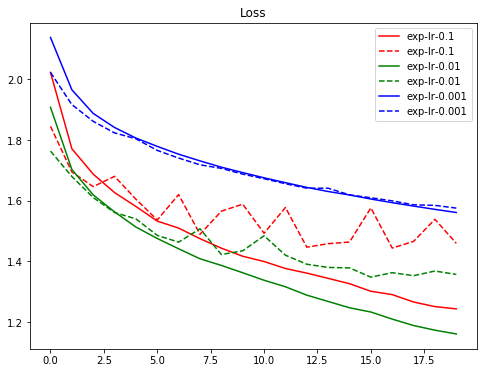

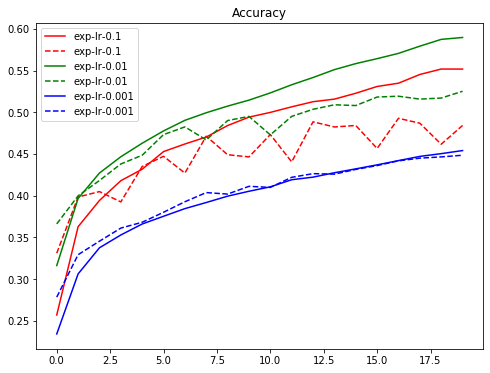

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# Adam

In [12]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.3f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    # Set optimizer
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 14s 285us/step - loss: 1.9432 - accuracy: 0.2958 - val_loss: 1.7391 - val_accuracy: 0.3837
Epoch 2/20
50000/50000 [==============================] - 13s 264us/step - loss: 1.7093 - accuracy: 0.3885 - val_loss: 1.6953 - val_accuracy: 0.3917
Epoch 3/20
50000/50000 [==============================] - 13s 261us/step - loss: 1.6149 - accuracy: 0.4245 - val_loss: 1.5846 - val_accuracy: 0.4387
Epoch 4/20
50000/50000 [==============================] - 11s 223us/step - loss: 1.5641 - accuracy: 0.4421 - val_loss: 1.5291 - val_accuracy: 0.4562
Epoch 5/20
50000/50000 [==============================] - 14s 280us/step - loss: 1.5021 - accuracy: 0.4625 - val_loss: 1.5015 - val_accuracy: 0.4593
Epoch 6/20
50000/50000 [==============================] - 12s 234us/step - loss: 1.4692 - accuracy: 0.4769 - val_loss: 1.4957 - val_accuracy: 0.4697
Epoch 7/20
50000/50000 [==============================] 

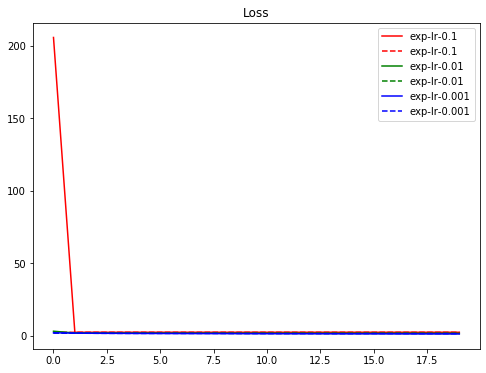

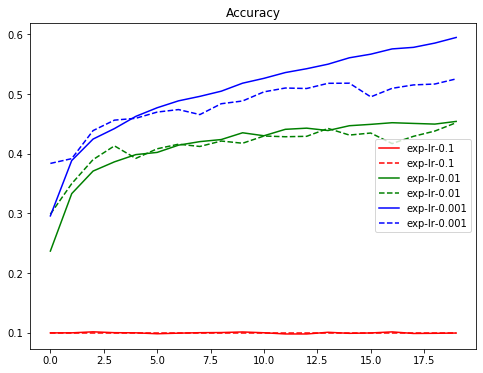

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# RMSprop

In [15]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.3f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    # Set optimizer
    optimizer = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=1e-07)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============

50000/50000 [==============================] - 12s 239us/step - loss: 1.7695 - accuracy: 0.3633 - val_loss: 1.9457 - val_accuracy: 0.319714 - 
Experiment with LR = 0.001
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
___________

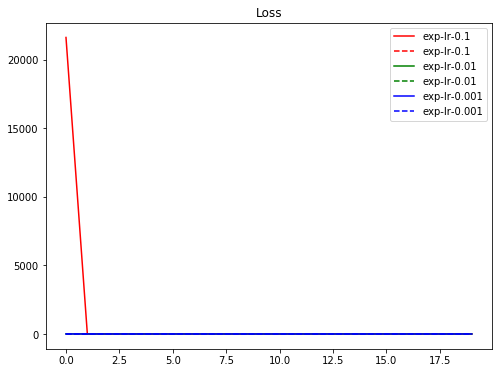

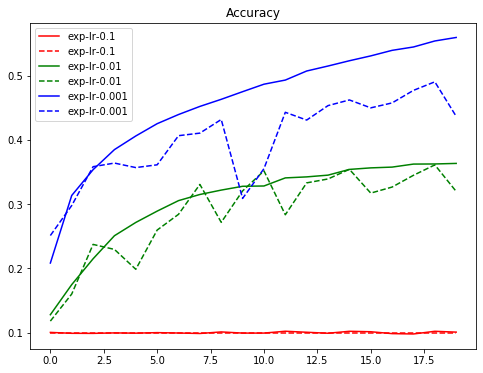

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()